# Imports

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from matplotlib.pyplot import figure
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from scipy import stats
import seaborn as sns
import powerlaw
from scipy.stats import poisson
from scipy.stats import norm  
from sklearn.model_selection import train_test_split
import math
from random import shuffle
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF
#from fa2 import ForceAtlas2
from scipy.spatial.distance import squareform
import joblib
import matplotlib
from sklearn.utils import column_or_1d
from sklearn.utils.multiclass import type_of_target
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.size'] = 15
from maximumentropymodels import *
import argparse
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from ogb.linkproppred import PygLinkPropPredDataset, Evaluator
from logger import Logger
import numpy as np
import pandas as pd
import networkx as nx
from tqdm import tqdm
from scipy.spatial.distance import squareform
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import sparse
import dask.array as da
from sklearn import metrics
from sklearn.metrics import average_precision_score

# Loading ogbl-ddi

In [2]:
dataset = PygLinkPropPredDataset(name='ogbl-ddi')
split_edge = dataset.get_edge_split()
data = dataset[0]

#device = f'cuda:{args.device}' if torch.cuda.is_available() else 'cpu'
#device = torch.device(device)
device = 'cpu'

x = data.x
pos_train_edge = split_edge['train']['edge'].to(device)
pos_valid_edge = split_edge['valid']['edge'].to(device)
neg_valid_edge = split_edge['valid']['edge_neg'].to(device)
pos_test_edge = split_edge['test']['edge'].to(device)
neg_test_edge = split_edge['test']['edge_neg'].to(device)

pos_train_edge_df = pd.DataFrame(pos_train_edge.numpy())
pos_valid_edge_df = pd.DataFrame(pos_valid_edge.numpy())
neg_valid_edge_df = pd.DataFrame(neg_valid_edge.numpy())
pos_test_edge_df = pd.DataFrame(pos_test_edge.numpy())
neg_test_edge_df = pd.DataFrame(neg_test_edge.numpy())

G_ddi = nx.from_pandas_edgelist(pos_train_edge_df, 0, 1, create_using=nx.Graph()) ## Training graph

# Configuration Models - Traditional and Duplex

In [3]:
def test_configuration_model(G, pos_test_edge_df, neg_test_edge_df, precision=10**(-5), loops=500, ts=0.3, typeneg='real'):

    netpos=nx.to_pandas_edgelist(G, source='node_1', target='node_2')
    netpos['binary_label']=[1 for c in range(netpos.shape[0])]
    print('density ', 2*len(G.edges)/N/(N-1)) 
    print('Positive Edgelist ', netpos.shape[0])
    Gc=nx.complement(G)
    print('Total Neg Edgelist ', len(Gc.edges))
    print('density ', 2*len(Gc.edges)/N/(N-1)) 
    
    if typeneg=='real':
        netneg=nx.to_pandas_edgelist(Gc, source='node_1', target='node_2')
    elif typeneg=='equal':
        netneg=nx.to_pandas_edgelist(Gc, source='node_1', target='node_2').sample(n=len(G.edges))
    else:
        return
    
    netneg['binary_label']=[0 for c in range(netneg.shape[0])]
    print('Negative Edgelist ', netneg.shape[0])
    network_data=pd.concat([netpos, netneg])
    network_data.reset_index(inplace=True)
    
    train = network_data.copy()

    ## Create train-test split
    test = pd.concat([pos_test_edge_df,neg_test_edge_df]).rename(columns={0:'node_1', 1:'node_2'})
    test['binary_label'] = [1] * len(pos_test_edge_df) + [0] * len(neg_test_edge_df) 
    
    #train, test = train_test_split(network_data, test_size=ts)

    train_nodes = list(set(train['node_1']).union(set(train['node_2'])))
    train_nodes_index_map = dict(zip(train_nodes, range(len(train_nodes)))) ## Mapping between training nodes and indices for selecting from summat matrices

    degree_train_1_0 = []
    degree_train_0_1 = []

    for node in tqdm(train_nodes):
        sub_df = train[(train['node_1'] == node) | (train['node_2'] == node)]
        degree_train_1_0.append(len(sub_df[sub_df['binary_label'] == 1]))
        degree_train_0_1.append(len(sub_df[sub_df['binary_label'] == 0]))
    
    
    degree_train_1_0=np.array([degree_train_1_0]).T
    degree_train_0_1=np.array([degree_train_0_1]).T

    sum_degree =  degree_train_1_0+degree_train_0_1
    print('Number of nodes with no positive annotation: ', sum(degree_train_1_0==0))
    print('Number of nodes with no negative annotation: ', sum(degree_train_0_1==0))
    print('Number of nodes with no pos or neg annotation: ', sum(sum_degree ==0))

    # standard configuration model
    (pconfstandard, kcal_confstandard)=configuration_model(degree_train_1_0, precision=precision, loops=loops)
    # configuration with positive and negative links
    (pconf01, k01cal, pconf10, k10cal, pconditional)=multidegree_entropy_pos_neg(degree_train_0_1, degree_train_1_0, precision=precision, loops=loops)

    test_probabilty_predicted = []
    test_probabilty_predicted_conditioned = []
    test_type_list = []

    ## Average conditional probability
    average_conditional_probability = sum(degree_train_1_0)/(sum(degree_train_1_0)+sum(degree_train_0_1))

    for index, row in tqdm(test.iterrows()):      
    
        if row['node_1'] in train_nodes and row['node_2'] in train_nodes:
            mapped_index_in_matrix_node_1 = train_nodes_index_map[row['node_1']]
            mapped_index_in_matrix_node_2 = train_nodes_index_map[row['node_2']]

            test_probabilty_predicted.append(pconfstandard[mapped_index_in_matrix_node_1, mapped_index_in_matrix_node_2])
            test_probabilty_predicted_conditioned.append(pconditional[mapped_index_in_matrix_node_1, mapped_index_in_matrix_node_2])
            test_type_list.append('Transductive')
        
        elif row['node_1'] in train_nodes and row['node_2'] not in train_nodes:
            mapped_index_in_matrix_node_1 = train_nodes_index_map[row['node_1']]

            test_probabilty_predicted.append(degree_train_1_0[mapped_index_in_matrix_node_1]/len(degree_train_1_0))
            ## k_+ / (k_+ + k_-)
            test_probabilty_predicted_conditioned.append(degree_train_1_0[mapped_index_in_matrix_node_1] / (degree_train_0_1[mapped_index_in_matrix_node_1] + degree_train_1_0[mapped_index_in_matrix_node_1] ))
            test_type_list.append('Semi-inductive')
        
        elif row['node_1'] not in train_nodes and row['node_2'] in train_nodes:
            mapped_index_in_matrix_node_2 = train_nodes_index_map[row['node_2']]

            test_probabilty_predicted.append(degree_train_1_0[mapped_index_in_matrix_node_2]/len(degree_train_1_0))
            test_probabilty_predicted_conditioned.append(degree_train_1_0[mapped_index_in_matrix_node_2] / (degree_train_0_1[mapped_index_in_matrix_node_2] + degree_train_1_0[mapped_index_in_matrix_node_2] ))
            test_type_list.append('Semi-inductive')
        
        else:
            test_probabilty_predicted.append(np.mean(degree_train_1_0)/(len(degree_train_1_0)-1))
            test_probabilty_predicted_conditioned.append(average_conditional_probability)
            test_type_list.append('Inductive')
        
    test_predictions = test.copy()
    test_predictions['predicted_probability'] = test_probabilty_predicted
    test_predictions['predicted_probability_duplex'] = test_probabilty_predicted_conditioned
    test_predictions['test_type'] = test_type_list

    return (test_predictions, degree_train_0_1, degree_train_1_0, pconfstandard, kcal_confstandard, pconf01, k01cal, pconf10, k10cal, pconditional)

# OGB Evaluation Metrics

In [4]:
def precision_at_k(y_true, y_score, k, pos_label=1):    
    y_true_type = type_of_target(y_true)
    if not (y_true_type == "binary"):
        raise ValueError("y_true must be a binary column.")
    
    # Makes this compatible with various array types
    y_true_arr = column_or_1d(y_true)
    y_score_arr = column_or_1d(y_score)
    
    y_true_arr = y_true_arr == pos_label
    
    desc_sort_order = np.argsort(y_score_arr)[::-1]
    y_true_sorted = y_true_arr[desc_sort_order]
    y_score_sorted = y_score_arr[desc_sort_order]
    
    true_positives = y_true_sorted[:k].sum()
    
    print('Baseline ', sum(y_true)/len(y_true))
    
    return true_positives / k

In [5]:
def recall_at_k(y_true, y_score, k, pos_label=1):
    from sklearn.utils import column_or_1d
    from sklearn.utils.multiclass import type_of_target
    
    y_true_type = type_of_target(y_true)
    if not (y_true_type == "binary"):
        raise ValueError("y_true must be a binary column.")
    
    # Makes this compatible with various array types
    y_true_arr = column_or_1d(y_true)
    y_score_arr = column_or_1d(y_score)
    
    y_true_arr = y_true_arr == pos_label
    
    desc_sort_order = np.argsort(y_score_arr)[::-1]
    y_true_sorted = y_true_arr[desc_sort_order]
    y_score_sorted = y_score_arr[desc_sort_order]
    
    true_positives = y_true_sorted[:k].sum()
    
    print('Baseline ', k/len(y_true))
    
    return true_positives / y_true_arr.sum()

In [6]:
def summary_performance(test_p, typetest='Transductive', typepred='predicted_probability', k=100):
    selt=test_p[test_p['test_type'] == typetest]
    print(typetest+' performance:')
    print('AUC: ', roc_auc_score(selt['binary_label'].tolist(), selt[typepred].tolist()))
    print('AUP: ', average_precision_score(selt['binary_label'].tolist(), selt[typepred].tolist()))
    print('Precision at '+str(k)+' ', precision_at_k(selt['binary_label'].tolist(),selt[typepred].tolist(), k))
    print('Recall at '+str(k)+' ', recall_at_k(selt['binary_label'].tolist(),selt[typepred].tolist(), k))

# Network Stats

In [7]:
N=len(G_ddi.nodes())

In [8]:
#denisty
density=2*len(G_ddi.edges)/N/(N-1)
perc_split_train=0.7
print(density)

0.11733337464515507


# Sampling all non-edges during Training

In [9]:
(test_predictions, degree_train_0_1, degree_train_1_0, pconfstandard, kcal_confstandard, pconf01, k01cal, pconf10, k10cal, pconditional)=test_configuration_model(G_ddi, pos_test_edge_df, neg_test_edge_df)

density  0.11733337464515507
Positive Edgelist  1067911
Total Neg Edgelist  8033600
density  0.882666625354845
Negative Edgelist  8033600


  0%|          | 0/500 [00:00<?, ?it/s]

Number of nodes with no positive annotation:  [0]
Number of nodes with no negative annotation:  [0]
Number of nodes with no pos or neg annotation:  [0]


  6%|▌         | 30/500 [00:08<02:10,  3.61it/s]


Loops  31
Error margin:  [8.41041271e-06]


100%|██████████| 500/500 [06:21<00:00,  1.31it/s]


Loops  500
Error margin:  [0.]


229088it [01:15, 3050.43it/s]


In [10]:
# desity of real links in the test
test_predictions['binary_label'].sum()/test_predictions.shape[0]

0.5826974786981421

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


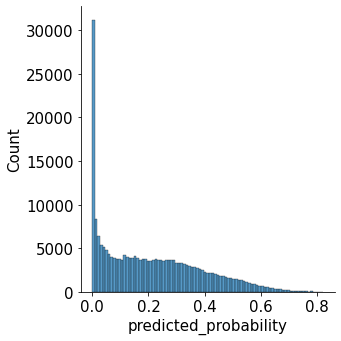

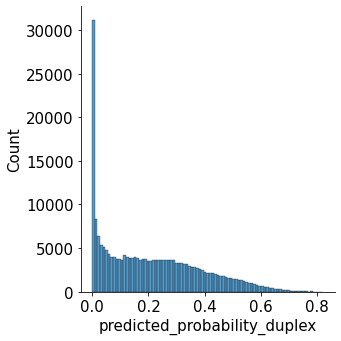

In [11]:
sns.displot(test_predictions['predicted_probability'])
sns.displot(test_predictions['predicted_probability_duplex'])

In [12]:
#expected probability for the standard configuration model
density*perc_split_train

0.08213336225160854

In [13]:
summary_performance(test_predictions, typepred='predicted_probability', k=1000)

Transductive performance:
AUC:  0.8777195928991451
AUP:  0.9011274790908715
Baseline  0.5826974786981421
Precision at 1000  0.999
Baseline  0.00436513479536248
Recall at 1000  0.007483762707039532


In [14]:
summary_performance(test_predictions, typepred='predicted_probability_duplex',k=1000)

Transductive performance:
AUC:  0.8777205834241055
AUP:  0.9011282450802832
Baseline  0.5826974786981421
Precision at 1000  0.999
Baseline  0.00436513479536248
Recall at 1000  0.007483762707039532


In [15]:
summary_performance(test_predictions, typepred='predicted_probability', k=20)

Transductive performance:
AUC:  0.8777195928991451
AUP:  0.9011274790908715
Baseline  0.5826974786981421
Precision at 20  1.0
Baseline  8.730269590724962e-05
Recall at 20  0.00014982507922001065


In [16]:
summary_performance(test_predictions, typepred='predicted_probability_duplex', k=20)

Transductive performance:
AUC:  0.8777205834241055
AUP:  0.9011282450802832
Baseline  0.5826974786981421
Precision at 20  1.0
Baseline  8.730269590724962e-05
Recall at 20  0.00014982507922001065


# Equal sampling of edges and non-edges during training

In [17]:
(test_predictions, degree_train_0_1, degree_train_1_0, pconfstandard, kcal_confstandard, pconf01, k01cal, pconf10, k10cal, pconditional)=test_configuration_model(G_ddi, pos_test_edge_df, neg_test_edge_df, typeneg='equal')


density  0.11733337464515507
Positive Edgelist  1067911
Total Neg Edgelist  8033600
density  0.882666625354845
Negative Edgelist  1067911


  0%|          | 0/500 [00:00<?, ?it/s]

Number of nodes with no positive annotation:  [0]
Number of nodes with no negative annotation:  [0]
Number of nodes with no pos or neg annotation:  [0]


  6%|▌         | 30/500 [00:08<02:09,  3.63it/s]


Loops  31
Error margin:  [7.95407075e-06]


  6%|▋         | 32/500 [00:25<06:07,  1.27it/s]


Loops  33
Error margin:  [7.63732e-06]


229088it [01:14, 3057.00it/s]


In [18]:
# desity of real links in the test
test_predictions['binary_label'].sum()/test_predictions.shape[0]

0.5826974786981421

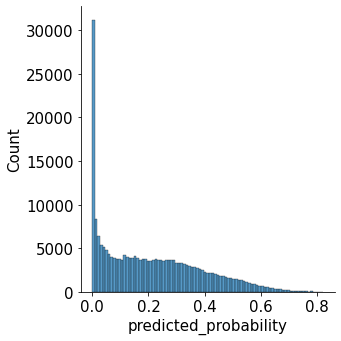

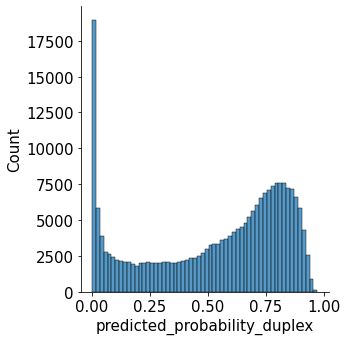

In [19]:
sns.displot(test_predictions['predicted_probability'])
sns.displot(test_predictions['predicted_probability_duplex'])

In [20]:
summary_performance(test_predictions, typepred='predicted_probability', k=1000)

Transductive performance:
AUC:  0.8777195961511356
AUP:  0.9011275080171713
Baseline  0.5826974786981421
Precision at 1000  0.999
Baseline  0.00436513479536248
Recall at 1000  0.007483762707039532


In [21]:
summary_performance(test_predictions, typepred='predicted_probability_duplex',k=1000)

Transductive performance:
AUC:  0.8773240717100605
AUP:  0.900585653007056
Baseline  0.5826974786981421
Precision at 1000  0.999
Baseline  0.00436513479536248
Recall at 1000  0.007483762707039532


In [22]:
summary_performance(test_predictions, typepred='predicted_probability', k=20)

Transductive performance:
AUC:  0.8777195961511356
AUP:  0.9011275080171713
Baseline  0.5826974786981421
Precision at 20  1.0
Baseline  8.730269590724962e-05
Recall at 20  0.00014982507922001065


In [24]:
summary_performance(test_predictions, typepred='predicted_probability_duplex',k=20)

Transductive performance:
AUC:  0.8773240717100605
AUP:  0.900585653007056
Baseline  0.5826974786981421
Precision at 20  1.0
Baseline  8.730269590724962e-05
Recall at 20  0.00014982507922001065
